In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


c:\Users\Shresth\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv("btc_data.csv",delimiter=";")

In [4]:
data.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,circulatingSupply,timestamp
0,2025-10-21T00:00:00.000Z,2025-10-21T23:59:59.999Z,2025-10-21T16:37:00.000Z,2025-10-21T08:48:00.000Z,2781,110587.629936,113996.346348,107534.749138,108476.886979,1.011944e+11,2.163102e+12,19937981,2025-10-21T23:59:59.999Z
1,2025-10-20T00:00:00.000Z,2025-10-20T23:59:59.999Z,2025-10-20T15:53:00.000Z,2025-10-20T00:34:00.000Z,2781,108667.443809,111711.033248,107485.014270,110588.930159,6.350779e+10,2.204869e+12,19937518,2025-10-20T23:59:59.999Z
2,2025-10-19T00:00:00.000Z,2025-10-19T23:59:59.999Z,2025-10-19T18:58:00.000Z,2025-10-19T09:30:00.000Z,2781,107204.314120,109488.992543,106157.790609,108666.711526,4.765701e+10,2.166469e+12,19936690,2025-10-19T23:59:59.999Z
3,2025-10-18T00:00:00.000Z,2025-10-18T23:59:59.999Z,2025-10-18T07:13:00.000Z,2025-10-18T00:17:00.000Z,2781,106483.735232,107490.981181,106387.449935,107198.266851,3.777991e+10,2.137289e+12,19936593,2025-10-18T23:59:59.999Z
4,2025-10-17T00:00:00.000Z,2025-10-17T23:59:59.999Z,2025-10-17T04:03:00.000Z,2025-10-17T10:25:00.000Z,2781,108179.134712,109235.807656,103598.428851,106467.785228,9.970305e+10,2.122870e+12,19936096,2025-10-17T23:59:59.999Z


In [5]:
# adjust path/sep as needed
df = pd.read_csv(
    "btc_data.csv",
    parse_dates=[
        "timeOpen","timeClose","timeHigh","timeLow","timestamp"
    ],
    sep=';', engine="python"  # auto-detect tab/comma
)
df = df.sort_values("timestamp").reset_index(drop=True)
print("Rows:", len(df))
df.head()

Rows: 398


,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,circulatingSupply,timestamp
0,2024-09-19 00:00:00+00:00,2024-09-19 23:59:59.999000+00:00,2024-09-19 17:47:00+00:00,2024-09-19 01:36:00+00:00,2781,61651.155338,63872.440722,61609.867021,62940.456766,4.271025e+10,1.243490e+12,19756303,2024-09-19 23:59:59.999000+00:00
1,2024-09-20 00:00:00+00:00,2024-09-20 23:59:59.999000+00:00,2024-09-20 04:10:00+00:00,2024-09-20 18:12:00+00:00,2781,62941.427595,64119.530360,62364.606533,63192.975083,3.517716e+10,1.248318e+12,19756762,2024-09-20 23:59:59.999000+00:00
2,2024-09-21 00:00:00+00:00,2024-09-21 23:59:59.999000+00:00,2024-09-21 23:51:00+00:00,2024-09-21 05:08:00+00:00,2781,63184.341268,63543.360123,62783.105380,63394.838743,1.440862e+10,1.252541e+12,19757171,2024-09-21 23:59:59.999000+00:00
3,2024-09-22 00:00:00+00:00,2024-09-22 23:59:59.999000+00:00,2024-09-22 22:59:00+00:00,2024-09-22 22:06:00+00:00,2781,63396.803553,63993.423103,62440.726268,63648.709890,2.018335e+10,1.257435e+12,19757593,2024-09-22 23:59:59.999000+00:00
4,2024-09-23 00:00:00+00:00,2024-09-23 23:59:59.999000+00:00,2024-09-23 03:28:00+00:00,2024-09-23 00:17:00+00:00,2781,63643.102080,64733.557668,62628.078664,63329.802387,3.140029e+10,1.251215e+12,19758050,2024-09-23 23:59:59.999000+00:00


In [6]:
# 1) Categorical ticker → integer code
df["name_code"] = pd.factorize(df["name"])[0]

# 2) Simple returns & spreads
df["ret_oc"]    = (df["close"] - df["open"]) / df["open"]
df["spread_hl"] = (df["high"] - df["low"])   / df["open"]

# 3) First differences
df["vol_chg"]   = df["volume"].pct_change()
df["mcap_chg"]  = df["marketCap"].pct_change()
df["supply_chg"]= df["circulatingSupply"].pct_change()

# 4) 5-day rolling stats
df["ma5_close"] = df["close"].rolling(5).mean()
df["std5_close"]= df["close"].rolling(5).std()
df["ma5_vol"]   = df["volume"].rolling(5).mean()
df["std5_vol"]  = df["volume"].rolling(5).std()

# 5) Time-cyclic features for when high/low occurred
def frac_of_day(ts):
    secs = ts.dt.hour*3600 + ts.dt.minute*60 + ts.dt.second
    return secs / 86400.0

for col in ["timeHigh","timeLow"]:
    f = frac_of_day(df[col])
    df[f"{col}_sin"] = np.sin(2*np.pi*f)
    df[f"{col}_cos"] = np.cos(2*np.pi*f)

# 6) Day-of-week cyclic
dow = df["timestamp"].dt.dayofweek / 6.0
df["dow_sin"] = np.sin(2*np.pi*dow)
df["dow_cos"] = np.cos(2*np.pi*dow)

# 7) Target: next-bar up/down
df["next_close"] = df["close"].shift(-1)
df["y"] = (df["next_close"] > df["close"]).astype(int)

# 8) Drop NaNs
df = df.dropna().reset_index(drop=True)
print("After feature engineering:", len(df))

After feature engineering: 393


In [7]:
from sklearn.preprocessing import MinMaxScaler

# List all numeric feature columns
num_cols = [
    
  "name_code","open","high","low","close","volume",
  "marketCap","circulatingSupply",
  "ret_oc","spread_hl","vol_chg","mcap_chg","supply_chg",
  "ma5_close","std5_close","ma5_vol","std5_vol",
  "timeHigh_sin","timeHigh_cos","timeLow_sin","timeLow_cos",
  "dow_sin","dow_cos"
]

# scale to [0,1] on train+val only
N = len(df)
seq_len = 10
num_samples = N - seq_len
train_end = int(num_samples * 0.8)
val_end   = int(num_samples * 0.9)

scaler = MinMaxScaler()
# fit on first 90% of rows
scaler.fit(df.loc[: val_end+seq_len, num_cols])
df[num_cols] = scaler.transform(df[num_cols])

# Prepare arrays
features = df[num_cols].values.astype(np.float32)
labels   = df["y"].values.astype(np.int64)
timestamps = df["timestamp"].values

In [8]:
class SequenceDataset(Dataset):
    def __init__(self, feats, labels, seq_len):
        self.feats = feats
        self.labels= labels
        self.seq_len = seq_len
        self.n = len(feats) - seq_len

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        x = self.feats[i : i+self.seq_len]
        y = self.labels[i + self.seq_len]
        return torch.from_numpy(x), torch.tensor([y], dtype=torch.float32)

full_ds = SequenceDataset(features, labels, seq_len)

In [9]:
train_idx = list(range(0, train_end))
val_idx   = list(range(train_end, val_end))
test_idx  = list(range(val_end, num_samples))

train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)
test_ds  = Subset(full_ds, test_idx)

def make_loader(ds, bs, shuffle):
    return DataLoader(ds, batch_size=bs, shuffle=shuffle)

# we'll optimize batch_size in Optuna

In [10]:
class ImprovedLSTM(nn.Module):
    def __init__(
        self,
        n_features,
        hidden_size,
        num_layers,
        dropout,
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(hidden_size//2, 1),
        )

    def forward(self, x):
        # x: (B, seq_len, n_features)
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)  # raw logit

In [11]:
def objective(trial):
    # hyperparam search space
    hidden_size = trial.suggest_int("hidden_size", 32, 256, log=True)
    num_layers  = trial.suggest_int("num_layers", 1, 4)
    dropout     = trial.suggest_float("dropout", 0.0, 0.5)
    lr          = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size  = trial.suggest_categorical("batch_size", [32, 64, 128])
    weight_decay = trial.suggest_float("wd", 1e-8, 1e-2, log=True)

    # loaders
    train_loader = make_loader(train_ds, batch_size, shuffle=True)
    val_loader   = make_loader(val_ds,   batch_size, shuffle=False)

    # model / opt / loss
    model = ImprovedLSTM(
        n_features=len(num_cols),
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
    ).to(device)
    optim = torch.optim.Adam(
        model.parameters(), lr=lr, weight_decay=weight_decay
    )
    loss_fn = nn.BCEWithLogitsLoss()

    best_val = 0.0
    patience, no_imp = 5, 0
    max_epochs = 50

    for epoch in range(1, max_epochs+1):
        # train
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optim.zero_grad()
            logits = model(xb)
            loss   = loss_fn(logits, yb)
            loss.backward()
            optim.step()

        # validate
        model.eval()
        all_pred, all_true = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                preds  = (torch.sigmoid(logits)>0.5).float()
                all_pred.append(preds.cpu())
                all_true.append(yb.cpu())
        all_pred = torch.cat(all_pred).numpy().flatten()
        all_true = torch.cat(all_true).numpy().flatten()
        val_acc = accuracy_score(all_true, all_pred)

        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if val_acc > best_val:
            best_val, no_imp = val_acc, 0
        else:
            no_imp += 1
            if no_imp >= patience:
                break

    return best_val

sampler = TPESampler(seed=42)
pruner  = MedianPruner(n_startup_trials=5)
study   = optuna.create_study(
    direction="maximize", sampler=sampler, pruner=pruner
)
study.optimize(objective, n_trials=30)
print("Best val accuracy:", study.best_value)
print("Best params:", study.best_params)

[I 2025-10-22 23:13:42,047] A new study created in memory with name: no-name-2857dc79-e5ec-4d82-bec6-d708cf3a9bd9
[I 2025-10-22 23:13:48,338] Trial 0 finished with value: 0.5 and parameters: {'hidden_size': 69, 'num_layers': 4, 'dropout': 0.36599697090570255, 'lr': 0.0015751320499779737, 'batch_size': 32, 'wd': 0.0015741890047456662}. Best is trial 0 with value: 0.5.
[I 2025-10-22 23:13:49,246] Trial 1 finished with value: 0.5 and parameters: {'hidden_size': 111, 'num_layers': 3, 'dropout': 0.010292247147901223, 'lr': 0.008706020878304856, 'batch_size': 32, 'wd': 1.2601639723276798e-07}. Best is trial 0 with value: 0.5.
[I 2025-10-22 23:13:50,175] Trial 2 finished with value: 0.5 and parameters: {'hidden_size': 60, 'num_layers': 3, 'dropout': 0.21597250932105788, 'lr': 0.0003823475224675188, 'batch_size': 32, 'wd': 1.5782327810795563e-06}. Best is trial 0 with value: 0.5.
[I 2025-10-22 23:13:50,567] Trial 3 finished with value: 0.5 and parameters: {'hidden_size': 82, 'num_layers': 4, '

Best val accuracy: 0.6842105263157895
Best params: {'hidden_size': 50, 'num_layers': 1, 'dropout': 0.07507374600405531, 'lr': 0.002422182120056661, 'batch_size': 64, 'wd': 2.9905131415247915e-05}


In [12]:
# retrain on train+val
best = study.best_params
# combine ds
trainval_idx = train_idx + val_idx
trainval_ds  = Subset(full_ds, trainval_idx)
loader_tv = make_loader(trainval_ds, best["batch_size"], shuffle=True)
test_loader= make_loader(test_ds, best["batch_size"], shuffle=False)

model = ImprovedLSTM(
    n_features=len(num_cols),
    hidden_size=best["hidden_size"],
    num_layers=best["num_layers"],
    dropout=best["dropout"],
).to(device)
optim = torch.optim.Adam(
    model.parameters(), lr=best["lr"], weight_decay=best["wd"]
)
loss_fn = nn.BCEWithLogitsLoss()

# quick train  max_epochs=50, no early stopping
for epoch in range(1, 51):
    model.train()
    for xb, yb in loader_tv:
        xb, yb = xb.to(device), yb.to(device)
        optim.zero_grad()
        loss_fn(model(xb), yb).backward()
        optim.step()

# test
model.eval()
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        p = (torch.sigmoid(model(xb))>0.5).float()
        preds.append(p.cpu())
        trues.append(yb.cpu())
preds = torch.cat(preds).numpy().flatten()
trues = torch.cat(trues).numpy().flatten()
test_acc = accuracy_score(trues, preds) * 100
print(f"Test directional accuracy: {test_acc:.2f}%")

c:\Users\Shresth\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.07507374600405531 and num_layers=1
  warnings.warn(


Test directional accuracy: 58.97%


c:\Users\Shresth\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.07507374600405531 and num_layers=1
  warnings.warn(


Test directional accuracy: 64.10%


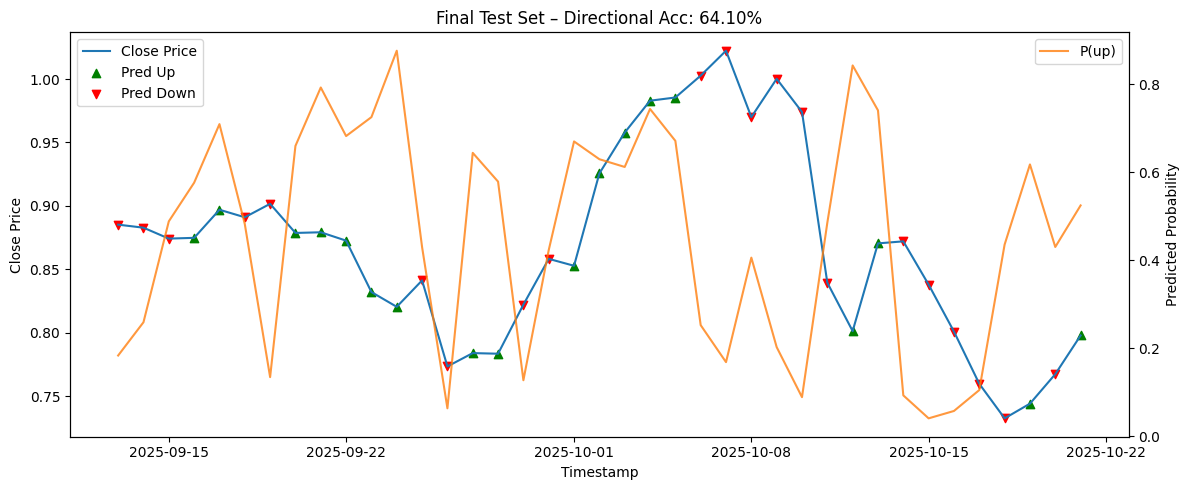

In [13]:
import torch
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 1) Re‐build the train+val and test datasets & loaders
best = study.best_params
trainval_idx = train_idx + val_idx
trainval_ds  = Subset(full_ds, trainval_idx)
test_ds      = Subset(full_ds, test_idx)

tv_loader = DataLoader(trainval_ds, batch_size=best["batch_size"], shuffle=True)
test_loader = DataLoader(test_ds, batch_size=best["batch_size"], shuffle=False)

# 2) Instantiate and train the final model
model = ImprovedLSTM(
    n_features=len(num_cols),
    hidden_size=best["hidden_size"],
    num_layers=best["num_layers"],
    dropout=best["dropout"],
).to(device)

optim = torch.optim.Adam(
    model.parameters(), lr=best["lr"], weight_decay=best["wd"]
)
loss_fn = nn.BCEWithLogitsLoss()

# simple retrain loop (no early stopping)
for epoch in range(1, 51):
    model.train()
    for xb, yb in tv_loader:
        xb, yb = xb.to(device), yb.to(device)
        optim.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optim.step()

# 3) Evaluate on TEST
model.eval()
all_preds, all_probs, all_trues = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb).cpu()
        probs  = torch.sigmoid(logits).numpy().flatten()
        preds  = (probs > 0.5).astype(int)
        all_probs.extend(probs.tolist())
        all_preds.extend(preds.tolist())
        all_trues.extend(yb.numpy().flatten().astype(int).tolist())

test_acc = accuracy_score(all_trues, all_preds) * 100
print(f"Test directional accuracy: {test_acc:.2f}%")

# 4) Reconstruct timestamps & raw prices for the test split
ts_test    = [timestamps[i + seq_len] for i in test_idx]
price_test = df["close"].values[[i + seq_len for i in test_idx]]

# 5) Plot
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(ts_test, price_test, color="tab:blue", label="Close Price")
# up/down markers
up_idx   = [i for i,p in enumerate(all_preds) if p==1]
down_idx = [i for i,p in enumerate(all_preds) if p==0]
ax1.scatter([ts_test[i] for i in up_idx],   [price_test[i] for i in up_idx],
            marker="^", c="green", label="Pred Up")
ax1.scatter([ts_test[i] for i in down_idx], [price_test[i] for i in down_idx],
            marker="v", c="red",   label="Pred Down")
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Close Price")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(ts_test, all_probs, color="tab:orange", label="P(up)", alpha=0.8)
ax2.set_ylabel("Predicted Probability")
ax2.legend(loc="upper right")

plt.title(f"Final Test Set – Directional Acc: {test_acc:.2f}%")
plt.tight_layout()
plt.show()